In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b10_b25_b50_b75_t1_mask_t1_normalized_k5_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 460)
(772408, 8)
validation
(101248, 460)
(101248, 8)
test
(98888, 460)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 1024)              472064    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1162120 (4.43 MB)


Trainable params: 1162120 (4.43 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:38 - loss: 2.3619 - STD: 0.0878 - MAE: 0.2234

 6/78 [=>............................] - ETA: 0s - loss: 1.6308 - STD: 0.1505 - MAE: 0.1708  

11/78 [===>..........................] - ETA: 0s - loss: 1.5131 - STD: 0.1887 - MAE: 0.1520

16/78 [=====>........................] - ETA: 0s - loss: 1.4590 - STD: 0.1887 - MAE: 0.1504

17/78 [=====>........................] - ETA: 2s - loss: 1.4570 - STD: 0.1883 - MAE: 0.1503

22/78 [=======>......................] - ETA: 2s - loss: 1.4256 - STD: 0.1892 - MAE: 0.1491

27/78 [=========>....................] - ETA: 1s - loss: 1.4080 - STD: 0.1913 - MAE: 0.1478

32/78 [===========>..................] - ETA: 1s - loss: 1.3942 - STD: 0.1914 - MAE: 0.1474

37/78 [=============>................] - ETA: 1s - loss: 1.3843 - STD: 0.1909 - MAE: 0.1473

42/78 [===============>..............] - ETA: 0s - loss: 1.3757 - STD: 0.1915 - MAE: 0.1469

47/78 [=================>............] - ETA: 0s - loss: 1.3697 - STD: 0.1921 - MAE: 0.1465

52/78 [===================>..........] - ETA: 0s - loss: 1.3644 - STD: 0.1918 - MAE: 0.1465

57/78 [====================>.........] - ETA: 0s - loss: 1.3598 - STD: 0.1914 - MAE: 0.1465

62/78 [======================>.......] - ETA: 0s - loss: 1.3562 - STD: 0.1916 - MAE: 0.1464

67/78 [========================>.....] - ETA: 0s - loss: 1.3541 - STD: 0.1916 - MAE: 0.1463

72/78 [==========================>...] - ETA: 0s - loss: 1.3508 - STD: 0.1914 - MAE: 0.1463

77/78 [============================>.] - ETA: 0s - loss: 1.3492 - STD: 0.1915 - MAE: 0.1463

78/78 [==============================] - 3s 29ms/step - loss: 1.3489 - STD: 0.1915 - MAE: 0.1463 - val_loss: 1.2745 - val_STD: 0.1904 - val_MAE: 0.1455


Epoch 2/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3123 - STD: 0.1904 - MAE: 0.1456

 6/78 [=>............................] - ETA: 0s - loss: 1.3221 - STD: 0.1891 - MAE: 0.1466

11/78 [===>..........................] - ETA: 0s - loss: 1.3191 - STD: 0.1902 - MAE: 0.1460

16/78 [=====>........................] - ETA: 0s - loss: 1.3189 - STD: 0.1914 - MAE: 0.1455

21/78 [=======>......................] - ETA: 0s - loss: 1.3169 - STD: 0.1911 - MAE: 0.1455

26/78 [=========>....................] - ETA: 0s - loss: 1.3147 - STD: 0.1915 - MAE: 0.1453

31/78 [==========>...................] - ETA: 0s - loss: 1.3154 - STD: 0.1917 - MAE: 0.1453

36/78 [============>.................] - ETA: 0s - loss: 1.3150 - STD: 0.1913 - MAE: 0.1454

41/78 [==============>...............] - ETA: 0s - loss: 1.3151 - STD: 0.1915 - MAE: 0.1453

46/78 [================>.............] - ETA: 0s - loss: 1.3160 - STD: 0.1915 - MAE: 0.1454

51/78 [==================>...........] - ETA: 0s - loss: 1.3163 - STD: 0.1914 - MAE: 0.1454

56/78 [====================>.........] - ETA: 0s - loss: 1.3160 - STD: 0.1914 - MAE: 0.1454

61/78 [======================>.......] - ETA: 0s - loss: 1.3160 - STD: 0.1914 - MAE: 0.1454

66/78 [========================>.....] - ETA: 0s - loss: 1.3161 - STD: 0.1915 - MAE: 0.1454

71/78 [==========================>...] - ETA: 0s - loss: 1.3159 - STD: 0.1914 - MAE: 0.1454

76/78 [============================>.] - ETA: 0s - loss: 1.3165 - STD: 0.1914 - MAE: 0.1455

78/78 [==============================] - 1s 14ms/step - loss: 1.3164 - STD: 0.1914 - MAE: 0.1455 - val_loss: 1.2741 - val_STD: 0.1915 - val_MAE: 0.1450


Epoch 3/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3142 - STD: 0.1914 - MAE: 0.1452

 6/78 [=>............................] - ETA: 0s - loss: 1.3173 - STD: 0.1925 - MAE: 0.1450

11/78 [===>..........................] - ETA: 0s - loss: 1.3131 - STD: 0.1922 - MAE: 0.1449

16/78 [=====>........................] - ETA: 0s - loss: 1.3139 - STD: 0.1920 - MAE: 0.1450

21/78 [=======>......................] - ETA: 0s - loss: 1.3158 - STD: 0.1919 - MAE: 0.1452

26/78 [=========>....................] - ETA: 0s - loss: 1.3157 - STD: 0.1917 - MAE: 0.1453

31/78 [==========>...................] - ETA: 0s - loss: 1.3159 - STD: 0.1918 - MAE: 0.1452

35/78 [============>.................] - ETA: 0s - loss: 1.3153 - STD: 0.1916 - MAE: 0.1453

40/78 [==============>...............] - ETA: 0s - loss: 1.3158 - STD: 0.1917 - MAE: 0.1453

45/78 [================>.............] - ETA: 0s - loss: 1.3158 - STD: 0.1916 - MAE: 0.1453

50/78 [==================>...........] - ETA: 0s - loss: 1.3152 - STD: 0.1916 - MAE: 0.1453

55/78 [====================>.........] - ETA: 0s - loss: 1.3153 - STD: 0.1916 - MAE: 0.1453

60/78 [======================>.......] - ETA: 0s - loss: 1.3143 - STD: 0.1916 - MAE: 0.1453

65/78 [========================>.....] - ETA: 0s - loss: 1.3135 - STD: 0.1916 - MAE: 0.1452

70/78 [=========================>....] - ETA: 0s - loss: 1.3130 - STD: 0.1915 - MAE: 0.1452

75/78 [===========================>..] - ETA: 0s - loss: 1.3126 - STD: 0.1914 - MAE: 0.1453

78/78 [==============================] - 1s 14ms/step - loss: 1.3123 - STD: 0.1915 - MAE: 0.1452 - val_loss: 1.2593 - val_STD: 0.1922 - val_MAE: 0.1441


Epoch 4/10000


 1/78 [..............................] - ETA: 2s - loss: 1.3105 - STD: 0.1885 - MAE: 0.1465

 6/78 [=>............................] - ETA: 0s - loss: 1.2969 - STD: 0.1914 - MAE: 0.1446

11/78 [===>..........................] - ETA: 0s - loss: 1.2940 - STD: 0.1918 - MAE: 0.1443

16/78 [=====>........................] - ETA: 0s - loss: 1.2920 - STD: 0.1923 - MAE: 0.1440

21/78 [=======>......................] - ETA: 0s - loss: 1.2901 - STD: 0.1928 - MAE: 0.1439

26/78 [=========>....................] - ETA: 0s - loss: 1.2871 - STD: 0.1932 - MAE: 0.1436

31/78 [==========>...................] - ETA: 0s - loss: 1.2851 - STD: 0.1936 - MAE: 0.1434

36/78 [============>.................] - ETA: 0s - loss: 1.2839 - STD: 0.1939 - MAE: 0.1432

41/78 [==============>...............] - ETA: 0s - loss: 1.2822 - STD: 0.1940 - MAE: 0.1432

46/78 [================>.............] - ETA: 0s - loss: 1.2816 - STD: 0.1944 - MAE: 0.1431

51/78 [==================>...........] - ETA: 0s - loss: 1.2798 - STD: 0.1944 - MAE: 0.1430

56/78 [====================>.........] - ETA: 0s - loss: 1.2790 - STD: 0.1945 - MAE: 0.1430

61/78 [======================>.......] - ETA: 0s - loss: 1.2778 - STD: 0.1946 - MAE: 0.1429

66/78 [========================>.....] - ETA: 0s - loss: 1.2765 - STD: 0.1946 - MAE: 0.1429

71/78 [==========================>...] - ETA: 0s - loss: 1.2751 - STD: 0.1948 - MAE: 0.1428

76/78 [============================>.] - ETA: 0s - loss: 1.2744 - STD: 0.1946 - MAE: 0.1429

78/78 [==============================] - 1s 14ms/step - loss: 1.2738 - STD: 0.1948 - MAE: 0.1428 - val_loss: 1.2078 - val_STD: 0.1935 - val_MAE: 0.1424


Epoch 5/10000


 1/78 [..............................] - ETA: 2s - loss: 1.2519 - STD: 0.1950 - MAE: 0.1422

 6/78 [=>............................] - ETA: 0s - loss: 1.2429 - STD: 0.1956 - MAE: 0.1416

11/78 [===>..........................] - ETA: 0s - loss: 1.2452 - STD: 0.1971 - MAE: 0.1411

16/78 [=====>........................] - ETA: 0s - loss: 1.2418 - STD: 0.1967 - MAE: 0.1412

21/78 [=======>......................] - ETA: 0s - loss: 1.2419 - STD: 0.1966 - MAE: 0.1413

26/78 [=========>....................] - ETA: 0s - loss: 1.2407 - STD: 0.1964 - MAE: 0.1413

31/78 [==========>...................] - ETA: 0s - loss: 1.2414 - STD: 0.1966 - MAE: 0.1413

36/78 [============>.................] - ETA: 0s - loss: 1.2394 - STD: 0.1964 - MAE: 0.1413

41/78 [==============>...............] - ETA: 0s - loss: 1.2385 - STD: 0.1965 - MAE: 0.1413

46/78 [================>.............] - ETA: 0s - loss: 1.2372 - STD: 0.1964 - MAE: 0.1412

51/78 [==================>...........] - ETA: 0s - loss: 1.2366 - STD: 0.1965 - MAE: 0.1412

56/78 [====================>.........] - ETA: 0s - loss: 1.2356 - STD: 0.1967 - MAE: 0.1411

61/78 [======================>.......] - ETA: 0s - loss: 1.2349 - STD: 0.1965 - MAE: 0.1411

66/78 [========================>.....] - ETA: 0s - loss: 1.2340 - STD: 0.1966 - MAE: 0.1411

71/78 [==========================>...] - ETA: 0s - loss: 1.2329 - STD: 0.1966 - MAE: 0.1410

76/78 [============================>.] - ETA: 0s - loss: 1.2317 - STD: 0.1966 - MAE: 0.1410

78/78 [==============================] - 1s 14ms/step - loss: 1.2308 - STD: 0.1968 - MAE: 0.1409 - val_loss: 1.1740 - val_STD: 0.2004 - val_MAE: 0.1384


Epoch 6/10000


 1/78 [..............................] - ETA: 2s - loss: 1.2125 - STD: 0.1977 - MAE: 0.1399

 6/78 [=>............................] - ETA: 0s - loss: 1.2043 - STD: 0.1981 - MAE: 0.1394

11/78 [===>..........................] - ETA: 0s - loss: 1.2046 - STD: 0.1984 - MAE: 0.1393

16/78 [=====>........................] - ETA: 0s - loss: 1.2039 - STD: 0.1986 - MAE: 0.1391

21/78 [=======>......................] - ETA: 0s - loss: 1.2036 - STD: 0.1987 - MAE: 0.1391

26/78 [=========>....................] - ETA: 0s - loss: 1.2036 - STD: 0.1987 - MAE: 0.1391

31/78 [==========>...................] - ETA: 0s - loss: 1.2025 - STD: 0.1990 - MAE: 0.1389

36/78 [============>.................] - ETA: 0s - loss: 1.2019 - STD: 0.1990 - MAE: 0.1389

41/78 [==============>...............] - ETA: 0s - loss: 1.2011 - STD: 0.1989 - MAE: 0.1389

46/78 [================>.............] - ETA: 0s - loss: 1.2005 - STD: 0.1991 - MAE: 0.1388

51/78 [==================>...........] - ETA: 0s - loss: 1.2013 - STD: 0.1992 - MAE: 0.1388

56/78 [====================>.........] - ETA: 0s - loss: 1.2020 - STD: 0.1994 - MAE: 0.1387

61/78 [======================>.......] - ETA: 0s - loss: 1.2021 - STD: 0.1994 - MAE: 0.1387

66/78 [========================>.....] - ETA: 0s - loss: 1.2014 - STD: 0.1994 - MAE: 0.1387

71/78 [==========================>...] - ETA: 0s - loss: 1.2010 - STD: 0.1996 - MAE: 0.1386

76/78 [============================>.] - ETA: 0s - loss: 1.2010 - STD: 0.1996 - MAE: 0.1386

78/78 [==============================] - 1s 14ms/step - loss: 1.2012 - STD: 0.1996 - MAE: 0.1386 - val_loss: 1.1564 - val_STD: 0.2018 - val_MAE: 0.1370


Epoch 7/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1864 - STD: 0.1968 - MAE: 0.1389

 6/78 [=>............................] - ETA: 0s - loss: 1.1894 - STD: 0.2014 - MAE: 0.1374

11/78 [===>..........................] - ETA: 0s - loss: 1.1884 - STD: 0.2013 - MAE: 0.1374

16/78 [=====>........................] - ETA: 0s - loss: 1.1899 - STD: 0.2012 - MAE: 0.1375

21/78 [=======>......................] - ETA: 0s - loss: 1.1904 - STD: 0.2004 - MAE: 0.1379

26/78 [=========>....................] - ETA: 0s - loss: 1.1898 - STD: 0.2005 - MAE: 0.1379

31/78 [==========>...................] - ETA: 0s - loss: 1.1890 - STD: 0.2006 - MAE: 0.1378

36/78 [============>.................] - ETA: 0s - loss: 1.1872 - STD: 0.2009 - MAE: 0.1376

41/78 [==============>...............] - ETA: 0s - loss: 1.1867 - STD: 0.2009 - MAE: 0.1376

46/78 [================>.............] - ETA: 0s - loss: 1.1875 - STD: 0.2009 - MAE: 0.1376

51/78 [==================>...........] - ETA: 0s - loss: 1.1874 - STD: 0.2007 - MAE: 0.1377

55/78 [====================>.........] - ETA: 0s - loss: 1.1858 - STD: 0.2008 - MAE: 0.1376

60/78 [======================>.......] - ETA: 0s - loss: 1.1853 - STD: 0.2010 - MAE: 0.1375

65/78 [========================>.....] - ETA: 0s - loss: 1.1852 - STD: 0.2012 - MAE: 0.1374

70/78 [=========================>....] - ETA: 0s - loss: 1.1846 - STD: 0.2013 - MAE: 0.1373

75/78 [===========================>..] - ETA: 0s - loss: 1.1834 - STD: 0.2014 - MAE: 0.1372

78/78 [==============================] - 1s 14ms/step - loss: 1.1830 - STD: 0.2013 - MAE: 0.1372 - val_loss: 1.1442 - val_STD: 0.2044 - val_MAE: 0.1353


Epoch 8/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1700 - STD: 0.2010 - MAE: 0.1367

 6/78 [=>............................] - ETA: 0s - loss: 1.1852 - STD: 0.2013 - MAE: 0.1374

11/78 [===>..........................] - ETA: 0s - loss: 1.1812 - STD: 0.2011 - MAE: 0.1373

16/78 [=====>........................] - ETA: 0s - loss: 1.1795 - STD: 0.2015 - MAE: 0.1371

21/78 [=======>......................] - ETA: 0s - loss: 1.1779 - STD: 0.2021 - MAE: 0.1368

26/78 [=========>....................] - ETA: 0s - loss: 1.1759 - STD: 0.2024 - MAE: 0.1365

31/78 [==========>...................] - ETA: 0s - loss: 1.1739 - STD: 0.2026 - MAE: 0.1363

36/78 [============>.................] - ETA: 0s - loss: 1.1723 - STD: 0.2027 - MAE: 0.1362

41/78 [==============>...............] - ETA: 0s - loss: 1.1707 - STD: 0.2029 - MAE: 0.1360

46/78 [================>.............] - ETA: 0s - loss: 1.1700 - STD: 0.2029 - MAE: 0.1360

51/78 [==================>...........] - ETA: 0s - loss: 1.1700 - STD: 0.2029 - MAE: 0.1360

56/78 [====================>.........] - ETA: 0s - loss: 1.1690 - STD: 0.2030 - MAE: 0.1359

61/78 [======================>.......] - ETA: 0s - loss: 1.1687 - STD: 0.2030 - MAE: 0.1359

66/78 [========================>.....] - ETA: 0s - loss: 1.1689 - STD: 0.2030 - MAE: 0.1359

71/78 [==========================>...] - ETA: 0s - loss: 1.1685 - STD: 0.2030 - MAE: 0.1359

76/78 [============================>.] - ETA: 0s - loss: 1.1685 - STD: 0.2031 - MAE: 0.1359

78/78 [==============================] - 1s 14ms/step - loss: 1.1690 - STD: 0.2032 - MAE: 0.1359 - val_loss: 1.1384 - val_STD: 0.2054 - val_MAE: 0.1345


Epoch 9/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1882 - STD: 0.2021 - MAE: 0.1375

 6/78 [=>............................] - ETA: 0s - loss: 1.1718 - STD: 0.2034 - MAE: 0.1359

11/78 [===>..........................] - ETA: 0s - loss: 1.1692 - STD: 0.2037 - MAE: 0.1356

16/78 [=====>........................] - ETA: 0s - loss: 1.1645 - STD: 0.2033 - MAE: 0.1356

21/78 [=======>......................] - ETA: 0s - loss: 1.1639 - STD: 0.2033 - MAE: 0.1356

26/78 [=========>....................] - ETA: 0s - loss: 1.1617 - STD: 0.2036 - MAE: 0.1354

31/78 [==========>...................] - ETA: 0s - loss: 1.1598 - STD: 0.2038 - MAE: 0.1353

36/78 [============>.................] - ETA: 0s - loss: 1.1603 - STD: 0.2037 - MAE: 0.1353

41/78 [==============>...............] - ETA: 0s - loss: 1.1595 - STD: 0.2037 - MAE: 0.1353

46/78 [================>.............] - ETA: 0s - loss: 1.1585 - STD: 0.2037 - MAE: 0.1353

51/78 [==================>...........] - ETA: 0s - loss: 1.1585 - STD: 0.2036 - MAE: 0.1354

56/78 [====================>.........] - ETA: 0s - loss: 1.1569 - STD: 0.2037 - MAE: 0.1353

61/78 [======================>.......] - ETA: 0s - loss: 1.1559 - STD: 0.2039 - MAE: 0.1351

66/78 [========================>.....] - ETA: 0s - loss: 1.1553 - STD: 0.2040 - MAE: 0.1351

71/78 [==========================>...] - ETA: 0s - loss: 1.1550 - STD: 0.2040 - MAE: 0.1351

76/78 [============================>.] - ETA: 0s - loss: 1.1548 - STD: 0.2040 - MAE: 0.1351

78/78 [==============================] - 1s 14ms/step - loss: 1.1546 - STD: 0.2040 - MAE: 0.1351 - val_loss: 1.1359 - val_STD: 0.2041 - val_MAE: 0.1349


Epoch 10/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1502 - STD: 0.2021 - MAE: 0.1360

 6/78 [=>............................] - ETA: 0s - loss: 1.1472 - STD: 0.2033 - MAE: 0.1354

11/78 [===>..........................] - ETA: 0s - loss: 1.1425 - STD: 0.2044 - MAE: 0.1346

16/78 [=====>........................] - ETA: 0s - loss: 1.1396 - STD: 0.2047 - MAE: 0.1343

21/78 [=======>......................] - ETA: 0s - loss: 1.1390 - STD: 0.2048 - MAE: 0.1342

26/78 [=========>....................] - ETA: 0s - loss: 1.1390 - STD: 0.2049 - MAE: 0.1343

31/78 [==========>...................] - ETA: 0s - loss: 1.1400 - STD: 0.2049 - MAE: 0.1343

36/78 [============>.................] - ETA: 0s - loss: 1.1412 - STD: 0.2050 - MAE: 0.1344

41/78 [==============>...............] - ETA: 0s - loss: 1.1412 - STD: 0.2050 - MAE: 0.1344

46/78 [================>.............] - ETA: 0s - loss: 1.1412 - STD: 0.2049 - MAE: 0.1344

51/78 [==================>...........] - ETA: 0s - loss: 1.1403 - STD: 0.2050 - MAE: 0.1343

56/78 [====================>.........] - ETA: 0s - loss: 1.1400 - STD: 0.2049 - MAE: 0.1343

61/78 [======================>.......] - ETA: 0s - loss: 1.1390 - STD: 0.2050 - MAE: 0.1342

66/78 [========================>.....] - ETA: 0s - loss: 1.1383 - STD: 0.2051 - MAE: 0.1342

71/78 [==========================>...] - ETA: 0s - loss: 1.1378 - STD: 0.2050 - MAE: 0.1342

76/78 [============================>.] - ETA: 0s - loss: 1.1375 - STD: 0.2051 - MAE: 0.1342

78/78 [==============================] - 1s 14ms/step - loss: 1.1371 - STD: 0.2051 - MAE: 0.1342 - val_loss: 1.1270 - val_STD: 0.2071 - val_MAE: 0.1334


Epoch 11/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1125 - STD: 0.2049 - MAE: 0.1329

 6/78 [=>............................] - ETA: 0s - loss: 1.1285 - STD: 0.2054 - MAE: 0.1337

11/78 [===>..........................] - ETA: 0s - loss: 1.1254 - STD: 0.2055 - MAE: 0.1335

16/78 [=====>........................] - ETA: 0s - loss: 1.1272 - STD: 0.2060 - MAE: 0.1334

21/78 [=======>......................] - ETA: 0s - loss: 1.1272 - STD: 0.2060 - MAE: 0.1335

26/78 [=========>....................] - ETA: 0s - loss: 1.1266 - STD: 0.2058 - MAE: 0.1335

31/78 [==========>...................] - ETA: 0s - loss: 1.1262 - STD: 0.2059 - MAE: 0.1335

36/78 [============>.................] - ETA: 0s - loss: 1.1265 - STD: 0.2056 - MAE: 0.1336

41/78 [==============>...............] - ETA: 0s - loss: 1.1263 - STD: 0.2058 - MAE: 0.1335

46/78 [================>.............] - ETA: 0s - loss: 1.1247 - STD: 0.2059 - MAE: 0.1334

51/78 [==================>...........] - ETA: 0s - loss: 1.1244 - STD: 0.2060 - MAE: 0.1334

56/78 [====================>.........] - ETA: 0s - loss: 1.1239 - STD: 0.2060 - MAE: 0.1334

61/78 [======================>.......] - ETA: 0s - loss: 1.1242 - STD: 0.2060 - MAE: 0.1333

66/78 [========================>.....] - ETA: 0s - loss: 1.1236 - STD: 0.2061 - MAE: 0.1333

70/78 [=========================>....] - ETA: 0s - loss: 1.1247 - STD: 0.2061 - MAE: 0.1333

75/78 [===========================>..] - ETA: 0s - loss: 1.1258 - STD: 0.2062 - MAE: 0.1333

78/78 [==============================] - 1s 13ms/step - loss: 1.1265 - STD: 0.2062 - MAE: 0.1334 - val_loss: 1.1471 - val_STD: 0.2085 - val_MAE: 0.1335


Epoch 12/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1376 - STD: 0.2050 - MAE: 0.1347

 5/78 [>.............................] - ETA: 1s - loss: 1.1319 - STD: 0.2059 - MAE: 0.1339

10/78 [==>...........................] - ETA: 0s - loss: 1.1271 - STD: 0.2055 - MAE: 0.1338

15/78 [====>.........................] - ETA: 0s - loss: 1.1218 - STD: 0.2063 - MAE: 0.1331

20/78 [======>.......................] - ETA: 0s - loss: 1.1200 - STD: 0.2068 - MAE: 0.1329

25/78 [========>.....................] - ETA: 0s - loss: 1.1214 - STD: 0.2066 - MAE: 0.1330

30/78 [==========>...................] - ETA: 0s - loss: 1.1195 - STD: 0.2066 - MAE: 0.1329

35/78 [============>.................] - ETA: 0s - loss: 1.1191 - STD: 0.2067 - MAE: 0.1329

40/78 [==============>...............] - ETA: 0s - loss: 1.1192 - STD: 0.2065 - MAE: 0.1330

45/78 [================>.............] - ETA: 0s - loss: 1.1188 - STD: 0.2065 - MAE: 0.1330

50/78 [==================>...........] - ETA: 0s - loss: 1.1189 - STD: 0.2065 - MAE: 0.1330

55/78 [====================>.........] - ETA: 0s - loss: 1.1186 - STD: 0.2065 - MAE: 0.1330

60/78 [======================>.......] - ETA: 0s - loss: 1.1181 - STD: 0.2066 - MAE: 0.1329

65/78 [========================>.....] - ETA: 0s - loss: 1.1176 - STD: 0.2066 - MAE: 0.1329

70/78 [=========================>....] - ETA: 0s - loss: 1.1172 - STD: 0.2067 - MAE: 0.1328

75/78 [===========================>..] - ETA: 0s - loss: 1.1167 - STD: 0.2068 - MAE: 0.1328

78/78 [==============================] - 1s 13ms/step - loss: 1.1162 - STD: 0.2068 - MAE: 0.1328 - val_loss: 1.1389 - val_STD: 0.2080 - val_MAE: 0.1334


Epoch 13/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1199 - STD: 0.2051 - MAE: 0.1339

 6/78 [=>............................] - ETA: 0s - loss: 1.1138 - STD: 0.2077 - MAE: 0.1324

11/78 [===>..........................] - ETA: 0s - loss: 1.1133 - STD: 0.2079 - MAE: 0.1322

16/78 [=====>........................] - ETA: 0s - loss: 1.1132 - STD: 0.2076 - MAE: 0.1323

21/78 [=======>......................] - ETA: 0s - loss: 1.1124 - STD: 0.2076 - MAE: 0.1323

26/78 [=========>....................] - ETA: 0s - loss: 1.1119 - STD: 0.2076 - MAE: 0.1323

31/78 [==========>...................] - ETA: 0s - loss: 1.1101 - STD: 0.2078 - MAE: 0.1321

36/78 [============>.................] - ETA: 0s - loss: 1.1109 - STD: 0.2076 - MAE: 0.1322

41/78 [==============>...............] - ETA: 0s - loss: 1.1106 - STD: 0.2078 - MAE: 0.1321

46/78 [================>.............] - ETA: 0s - loss: 1.1104 - STD: 0.2076 - MAE: 0.1322

51/78 [==================>...........] - ETA: 0s - loss: 1.1105 - STD: 0.2077 - MAE: 0.1322

56/78 [====================>.........] - ETA: 0s - loss: 1.1100 - STD: 0.2078 - MAE: 0.1321

61/78 [======================>.......] - ETA: 0s - loss: 1.1097 - STD: 0.2077 - MAE: 0.1321

66/78 [========================>.....] - ETA: 0s - loss: 1.1095 - STD: 0.2078 - MAE: 0.1321

71/78 [==========================>...] - ETA: 0s - loss: 1.1093 - STD: 0.2078 - MAE: 0.1321

76/78 [============================>.] - ETA: 0s - loss: 1.1092 - STD: 0.2078 - MAE: 0.1321

78/78 [==============================] - 1s 14ms/step - loss: 1.1091 - STD: 0.2079 - MAE: 0.1320 - val_loss: 1.1176 - val_STD: 0.2097 - val_MAE: 0.1317


Epoch 14/10000


 1/78 [..............................] - ETA: 2s - loss: 1.1195 - STD: 0.2066 - MAE: 0.1331

 6/78 [=>............................] - ETA: 0s - loss: 1.1096 - STD: 0.2069 - MAE: 0.1326

11/78 [===>..........................] - ETA: 0s - loss: 1.1070 - STD: 0.2072 - MAE: 0.1322

16/78 [=====>........................] - ETA: 0s - loss: 1.1057 - STD: 0.2079 - MAE: 0.1319

21/78 [=======>......................] - ETA: 0s - loss: 1.1054 - STD: 0.2081 - MAE: 0.1318

26/78 [=========>....................] - ETA: 0s - loss: 1.1051 - STD: 0.2080 - MAE: 0.1318

31/78 [==========>...................] - ETA: 0s - loss: 1.1059 - STD: 0.2081 - MAE: 0.1318

36/78 [============>.................] - ETA: 0s - loss: 1.1043 - STD: 0.2081 - MAE: 0.1317

41/78 [==============>...............] - ETA: 0s - loss: 1.1029 - STD: 0.2084 - MAE: 0.1316

46/78 [================>.............] - ETA: 0s - loss: 1.1037 - STD: 0.2081 - MAE: 0.1317

51/78 [==================>...........] - ETA: 0s - loss: 1.1040 - STD: 0.2083 - MAE: 0.1317

56/78 [====================>.........] - ETA: 0s - loss: 1.1045 - STD: 0.2082 - MAE: 0.1317

61/78 [======================>.......] - ETA: 0s - loss: 1.1043 - STD: 0.2082 - MAE: 0.1317

66/78 [========================>.....] - ETA: 0s - loss: 1.1040 - STD: 0.2082 - MAE: 0.1317

71/78 [==========================>...] - ETA: 0s - loss: 1.1040 - STD: 0.2084 - MAE: 0.1316

76/78 [============================>.] - ETA: 0s - loss: 1.1036 - STD: 0.2083 - MAE: 0.1316

78/78 [==============================] - 1s 14ms/step - loss: 1.1039 - STD: 0.2084 - MAE: 0.1316 - val_loss: 1.1074 - val_STD: 0.2059 - val_MAE: 0.1330


Epoch 15/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0952 - STD: 0.2032 - MAE: 0.1334

 6/78 [=>............................] - ETA: 0s - loss: 1.1052 - STD: 0.2080 - MAE: 0.1319

11/78 [===>..........................] - ETA: 0s - loss: 1.1056 - STD: 0.2078 - MAE: 0.1320

16/78 [=====>........................] - ETA: 0s - loss: 1.1030 - STD: 0.2080 - MAE: 0.1318

21/78 [=======>......................] - ETA: 0s - loss: 1.1025 - STD: 0.2079 - MAE: 0.1318

26/78 [=========>....................] - ETA: 0s - loss: 1.1033 - STD: 0.2084 - MAE: 0.1316

31/78 [==========>...................] - ETA: 0s - loss: 1.1038 - STD: 0.2080 - MAE: 0.1318

36/78 [============>.................] - ETA: 0s - loss: 1.1016 - STD: 0.2083 - MAE: 0.1316

41/78 [==============>...............] - ETA: 0s - loss: 1.1016 - STD: 0.2084 - MAE: 0.1316

45/78 [================>.............] - ETA: 0s - loss: 1.1011 - STD: 0.2085 - MAE: 0.1315

50/78 [==================>...........] - ETA: 0s - loss: 1.1004 - STD: 0.2087 - MAE: 0.1314

55/78 [====================>.........] - ETA: 0s - loss: 1.0996 - STD: 0.2087 - MAE: 0.1313

60/78 [======================>.......] - ETA: 0s - loss: 1.1002 - STD: 0.2087 - MAE: 0.1314

65/78 [========================>.....] - ETA: 0s - loss: 1.0997 - STD: 0.2087 - MAE: 0.1313

70/78 [=========================>....] - ETA: 0s - loss: 1.0994 - STD: 0.2087 - MAE: 0.1313

75/78 [===========================>..] - ETA: 0s - loss: 1.0995 - STD: 0.2088 - MAE: 0.1313

78/78 [==============================] - 1s 14ms/step - loss: 1.0996 - STD: 0.2088 - MAE: 0.1313 - val_loss: 1.1170 - val_STD: 0.2041 - val_MAE: 0.1339


Epoch 16/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0979 - STD: 0.2005 - MAE: 0.1345

 6/78 [=>............................] - ETA: 0s - loss: 1.0933 - STD: 0.2084 - MAE: 0.1311

10/78 [==>...........................] - ETA: 0s - loss: 1.0931 - STD: 0.2095 - MAE: 0.1306

14/78 [====>.........................] - ETA: 0s - loss: 1.0972 - STD: 0.2086 - MAE: 0.1312

19/78 [======>.......................] - ETA: 0s - loss: 1.0995 - STD: 0.2083 - MAE: 0.1314

24/78 [========>.....................] - ETA: 0s - loss: 1.0995 - STD: 0.2082 - MAE: 0.1315

29/78 [==========>...................] - ETA: 0s - loss: 1.1020 - STD: 0.2088 - MAE: 0.1314

34/78 [============>.................] - ETA: 0s - loss: 1.1025 - STD: 0.2088 - MAE: 0.1314

39/78 [==============>...............] - ETA: 0s - loss: 1.1026 - STD: 0.2087 - MAE: 0.1315

44/78 [===============>..............] - ETA: 0s - loss: 1.1017 - STD: 0.2090 - MAE: 0.1313

49/78 [=================>............] - ETA: 0s - loss: 1.1006 - STD: 0.2090 - MAE: 0.1313

54/78 [===================>..........] - ETA: 0s - loss: 1.1005 - STD: 0.2089 - MAE: 0.1313

59/78 [=====================>........] - ETA: 0s - loss: 1.0997 - STD: 0.2088 - MAE: 0.1313

64/78 [=======================>......] - ETA: 0s - loss: 1.0991 - STD: 0.2088 - MAE: 0.1313

69/78 [=========================>....] - ETA: 0s - loss: 1.0986 - STD: 0.2087 - MAE: 0.1313

73/78 [===========================>..] - ETA: 0s - loss: 1.0987 - STD: 0.2089 - MAE: 0.1313

78/78 [==============================] - ETA: 0s - loss: 1.0981 - STD: 0.2090 - MAE: 0.1312

78/78 [==============================] - 1s 14ms/step - loss: 1.0981 - STD: 0.2090 - MAE: 0.1312 - val_loss: 1.1218 - val_STD: 0.2048 - val_MAE: 0.1338


Epoch 17/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0979 - STD: 0.2019 - MAE: 0.1344

 6/78 [=>............................] - ETA: 0s - loss: 1.0950 - STD: 0.2091 - MAE: 0.1310

11/78 [===>..........................] - ETA: 0s - loss: 1.0992 - STD: 0.2086 - MAE: 0.1314

16/78 [=====>........................] - ETA: 0s - loss: 1.0966 - STD: 0.2096 - MAE: 0.1308

21/78 [=======>......................] - ETA: 0s - loss: 1.0972 - STD: 0.2085 - MAE: 0.1314

26/78 [=========>....................] - ETA: 0s - loss: 1.0968 - STD: 0.2086 - MAE: 0.1313

31/78 [==========>...................] - ETA: 0s - loss: 1.0969 - STD: 0.2088 - MAE: 0.1312

36/78 [============>.................] - ETA: 0s - loss: 1.0964 - STD: 0.2091 - MAE: 0.1311

41/78 [==============>...............] - ETA: 0s - loss: 1.0958 - STD: 0.2089 - MAE: 0.1311

46/78 [================>.............] - ETA: 0s - loss: 1.0949 - STD: 0.2090 - MAE: 0.1311

51/78 [==================>...........] - ETA: 0s - loss: 1.0937 - STD: 0.2091 - MAE: 0.1310

55/78 [====================>.........] - ETA: 0s - loss: 1.0928 - STD: 0.2091 - MAE: 0.1309

60/78 [======================>.......] - ETA: 0s - loss: 1.0930 - STD: 0.2091 - MAE: 0.1309

65/78 [========================>.....] - ETA: 0s - loss: 1.0930 - STD: 0.2091 - MAE: 0.1309

70/78 [=========================>....] - ETA: 0s - loss: 1.0929 - STD: 0.2091 - MAE: 0.1309

75/78 [===========================>..] - ETA: 0s - loss: 1.0926 - STD: 0.2092 - MAE: 0.1309

78/78 [==============================] - 1s 14ms/step - loss: 1.0923 - STD: 0.2092 - MAE: 0.1309 - val_loss: 1.1074 - val_STD: 0.2154 - val_MAE: 0.1288


Epoch 18/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0865 - STD: 0.2113 - MAE: 0.1295

 6/78 [=>............................] - ETA: 0s - loss: 1.0921 - STD: 0.2098 - MAE: 0.1307

11/78 [===>..........................] - ETA: 0s - loss: 1.0923 - STD: 0.2087 - MAE: 0.1311

16/78 [=====>........................] - ETA: 0s - loss: 1.0936 - STD: 0.2092 - MAE: 0.1309

21/78 [=======>......................] - ETA: 0s - loss: 1.0916 - STD: 0.2094 - MAE: 0.1307

26/78 [=========>....................] - ETA: 0s - loss: 1.0909 - STD: 0.2094 - MAE: 0.1307

31/78 [==========>...................] - ETA: 0s - loss: 1.0905 - STD: 0.2096 - MAE: 0.1306

36/78 [============>.................] - ETA: 0s - loss: 1.0903 - STD: 0.2095 - MAE: 0.1306

41/78 [==============>...............] - ETA: 0s - loss: 1.0894 - STD: 0.2097 - MAE: 0.1305

46/78 [================>.............] - ETA: 0s - loss: 1.0890 - STD: 0.2096 - MAE: 0.1305

51/78 [==================>...........] - ETA: 0s - loss: 1.0890 - STD: 0.2097 - MAE: 0.1305

56/78 [====================>.........] - ETA: 0s - loss: 1.0892 - STD: 0.2098 - MAE: 0.1304

61/78 [======================>.......] - ETA: 0s - loss: 1.0885 - STD: 0.2099 - MAE: 0.1304

66/78 [========================>.....] - ETA: 0s - loss: 1.0895 - STD: 0.2098 - MAE: 0.1304

71/78 [==========================>...] - ETA: 0s - loss: 1.0899 - STD: 0.2098 - MAE: 0.1305

76/78 [============================>.] - ETA: 0s - loss: 1.0901 - STD: 0.2097 - MAE: 0.1305

78/78 [==============================] - 1s 14ms/step - loss: 1.0898 - STD: 0.2098 - MAE: 0.1305 - val_loss: 1.1001 - val_STD: 0.2112 - val_MAE: 0.1303


Epoch 19/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0874 - STD: 0.2078 - MAE: 0.1312

 6/78 [=>............................] - ETA: 0s - loss: 1.0927 - STD: 0.2099 - MAE: 0.1306

11/78 [===>..........................] - ETA: 0s - loss: 1.0910 - STD: 0.2092 - MAE: 0.1308

15/78 [====>.........................] - ETA: 0s - loss: 1.0929 - STD: 0.2093 - MAE: 0.1309

19/78 [======>.......................] - ETA: 0s - loss: 1.0921 - STD: 0.2097 - MAE: 0.1307

23/78 [=======>......................] - ETA: 0s - loss: 1.0912 - STD: 0.2093 - MAE: 0.1308

27/78 [=========>....................] - ETA: 0s - loss: 1.0900 - STD: 0.2096 - MAE: 0.1306

31/78 [==========>...................] - ETA: 0s - loss: 1.0891 - STD: 0.2095 - MAE: 0.1306

36/78 [============>.................] - ETA: 0s - loss: 1.0887 - STD: 0.2095 - MAE: 0.1306

41/78 [==============>...............] - ETA: 0s - loss: 1.0880 - STD: 0.2097 - MAE: 0.1304

46/78 [================>.............] - ETA: 0s - loss: 1.0868 - STD: 0.2097 - MAE: 0.1304

51/78 [==================>...........] - ETA: 0s - loss: 1.0859 - STD: 0.2099 - MAE: 0.1303

56/78 [====================>.........] - ETA: 0s - loss: 1.0858 - STD: 0.2101 - MAE: 0.1302

61/78 [======================>.......] - ETA: 0s - loss: 1.0854 - STD: 0.2099 - MAE: 0.1303

66/78 [========================>.....] - ETA: 0s - loss: 1.0857 - STD: 0.2100 - MAE: 0.1302

71/78 [==========================>...] - ETA: 0s - loss: 1.0858 - STD: 0.2100 - MAE: 0.1302

76/78 [============================>.] - ETA: 0s - loss: 1.0860 - STD: 0.2101 - MAE: 0.1302

78/78 [==============================] - 1s 14ms/step - loss: 1.0858 - STD: 0.2100 - MAE: 0.1302 - val_loss: 1.1078 - val_STD: 0.2219 - val_MAE: 0.1263


Epoch 20/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0864 - STD: 0.2177 - MAE: 0.1271

 6/78 [=>............................] - ETA: 0s - loss: 1.0913 - STD: 0.2096 - MAE: 0.1307

11/78 [===>..........................] - ETA: 0s - loss: 1.0923 - STD: 0.2092 - MAE: 0.1309

16/78 [=====>........................] - ETA: 0s - loss: 1.0886 - STD: 0.2101 - MAE: 0.1303

21/78 [=======>......................] - ETA: 0s - loss: 1.0894 - STD: 0.2097 - MAE: 0.1305

26/78 [=========>....................] - ETA: 0s - loss: 1.0884 - STD: 0.2100 - MAE: 0.1304

31/78 [==========>...................] - ETA: 0s - loss: 1.0868 - STD: 0.2099 - MAE: 0.1303

36/78 [============>.................] - ETA: 0s - loss: 1.0854 - STD: 0.2103 - MAE: 0.1301

40/78 [==============>...............] - ETA: 0s - loss: 1.0838 - STD: 0.2105 - MAE: 0.1299

44/78 [===============>..............] - ETA: 0s - loss: 1.0839 - STD: 0.2104 - MAE: 0.1299

49/78 [=================>............] - ETA: 0s - loss: 1.0830 - STD: 0.2104 - MAE: 0.1299

54/78 [===================>..........] - ETA: 0s - loss: 1.0823 - STD: 0.2105 - MAE: 0.1298

58/78 [=====================>........] - ETA: 0s - loss: 1.0829 - STD: 0.2104 - MAE: 0.1299

62/78 [======================>.......] - ETA: 0s - loss: 1.0832 - STD: 0.2103 - MAE: 0.1300

66/78 [========================>.....] - ETA: 0s - loss: 1.0834 - STD: 0.2104 - MAE: 0.1300

70/78 [=========================>....] - ETA: 0s - loss: 1.0834 - STD: 0.2103 - MAE: 0.1300

74/78 [===========================>..] - ETA: 0s - loss: 1.0831 - STD: 0.2103 - MAE: 0.1300

78/78 [==============================] - 1s 14ms/step - loss: 1.0826 - STD: 0.2104 - MAE: 0.1299 - val_loss: 1.1125 - val_STD: 0.2155 - val_MAE: 0.1288


Epoch 21/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0828 - STD: 0.2112 - MAE: 0.1294

 5/78 [>.............................] - ETA: 0s - loss: 1.0780 - STD: 0.2104 - MAE: 0.1297

 9/78 [==>...........................] - ETA: 0s - loss: 1.0789 - STD: 0.2105 - MAE: 0.1298

14/78 [====>.........................] - ETA: 0s - loss: 1.0805 - STD: 0.2112 - MAE: 0.1294

18/78 [=====>........................] - ETA: 0s - loss: 1.0791 - STD: 0.2113 - MAE: 0.1293

23/78 [=======>......................] - ETA: 0s - loss: 1.0794 - STD: 0.2110 - MAE: 0.1295

27/78 [=========>....................] - ETA: 0s - loss: 1.0785 - STD: 0.2108 - MAE: 0.1296

31/78 [==========>...................] - ETA: 0s - loss: 1.0788 - STD: 0.2109 - MAE: 0.1295

35/78 [============>.................] - ETA: 0s - loss: 1.0782 - STD: 0.2111 - MAE: 0.1294

39/78 [==============>...............] - ETA: 0s - loss: 1.0779 - STD: 0.2110 - MAE: 0.1295

43/78 [===============>..............] - ETA: 0s - loss: 1.0782 - STD: 0.2110 - MAE: 0.1295

48/78 [=================>............] - ETA: 0s - loss: 1.0778 - STD: 0.2110 - MAE: 0.1294

52/78 [===================>..........] - ETA: 0s - loss: 1.0776 - STD: 0.2112 - MAE: 0.1293

56/78 [====================>.........] - ETA: 0s - loss: 1.0783 - STD: 0.2111 - MAE: 0.1294

61/78 [======================>.......] - ETA: 0s - loss: 1.0786 - STD: 0.2109 - MAE: 0.1295

65/78 [========================>.....] - ETA: 0s - loss: 1.0789 - STD: 0.2108 - MAE: 0.1296

69/78 [=========================>....] - ETA: 0s - loss: 1.0787 - STD: 0.2110 - MAE: 0.1295

74/78 [===========================>..] - ETA: 0s - loss: 1.0790 - STD: 0.2108 - MAE: 0.1296

78/78 [==============================] - 1s 14ms/step - loss: 1.0792 - STD: 0.2109 - MAE: 0.1296 - val_loss: 1.1014 - val_STD: 0.2142 - val_MAE: 0.1292


Epoch 22/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0696 - STD: 0.2102 - MAE: 0.1296

 6/78 [=>............................] - ETA: 0s - loss: 1.0693 - STD: 0.2111 - MAE: 0.1290

11/78 [===>..........................] - ETA: 0s - loss: 1.0742 - STD: 0.2112 - MAE: 0.1292

16/78 [=====>........................] - ETA: 0s - loss: 1.0767 - STD: 0.2107 - MAE: 0.1295

21/78 [=======>......................] - ETA: 0s - loss: 1.0783 - STD: 0.2111 - MAE: 0.1295

26/78 [=========>....................] - ETA: 0s - loss: 1.0801 - STD: 0.2112 - MAE: 0.1295

30/78 [==========>...................] - ETA: 0s - loss: 1.0817 - STD: 0.2111 - MAE: 0.1296

34/78 [============>.................] - ETA: 0s - loss: 1.0828 - STD: 0.2109 - MAE: 0.1298

39/78 [==============>...............] - ETA: 0s - loss: 1.0821 - STD: 0.2109 - MAE: 0.1297

44/78 [===============>..............] - ETA: 0s - loss: 1.0821 - STD: 0.2105 - MAE: 0.1299

49/78 [=================>............] - ETA: 0s - loss: 1.0826 - STD: 0.2105 - MAE: 0.1300

54/78 [===================>..........] - ETA: 0s - loss: 1.0823 - STD: 0.2106 - MAE: 0.1299

58/78 [=====================>........] - ETA: 0s - loss: 1.0829 - STD: 0.2105 - MAE: 0.1299

62/78 [======================>.......] - ETA: 0s - loss: 1.0821 - STD: 0.2106 - MAE: 0.1299

66/78 [========================>.....] - ETA: 0s - loss: 1.0822 - STD: 0.2104 - MAE: 0.1299

70/78 [=========================>....] - ETA: 0s - loss: 1.0816 - STD: 0.2104 - MAE: 0.1299

75/78 [===========================>..] - ETA: 0s - loss: 1.0812 - STD: 0.2106 - MAE: 0.1298

78/78 [==============================] - 1s 14ms/step - loss: 1.0813 - STD: 0.2106 - MAE: 0.1298 - val_loss: 1.1069 - val_STD: 0.2192 - val_MAE: 0.1276


Epoch 23/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0915 - STD: 0.2166 - MAE: 0.1278

 5/78 [>.............................] - ETA: 1s - loss: 1.0854 - STD: 0.2117 - MAE: 0.1294

 9/78 [==>...........................] - ETA: 0s - loss: 1.0836 - STD: 0.2114 - MAE: 0.1295

14/78 [====>.........................] - ETA: 0s - loss: 1.0814 - STD: 0.2103 - MAE: 0.1300

19/78 [======>.......................] - ETA: 0s - loss: 1.0797 - STD: 0.2106 - MAE: 0.1298

23/78 [=======>......................] - ETA: 0s - loss: 1.0786 - STD: 0.2108 - MAE: 0.1296

27/78 [=========>....................] - ETA: 0s - loss: 1.0782 - STD: 0.2107 - MAE: 0.1297

31/78 [==========>...................] - ETA: 0s - loss: 1.0776 - STD: 0.2108 - MAE: 0.1296

35/78 [============>.................] - ETA: 0s - loss: 1.0770 - STD: 0.2107 - MAE: 0.1296

39/78 [==============>...............] - ETA: 0s - loss: 1.0756 - STD: 0.2109 - MAE: 0.1295

43/78 [===============>..............] - ETA: 0s - loss: 1.0756 - STD: 0.2107 - MAE: 0.1295

48/78 [=================>............] - ETA: 0s - loss: 1.0763 - STD: 0.2108 - MAE: 0.1295

52/78 [===================>..........] - ETA: 0s - loss: 1.0768 - STD: 0.2109 - MAE: 0.1295

56/78 [====================>.........] - ETA: 0s - loss: 1.0764 - STD: 0.2109 - MAE: 0.1295

60/78 [======================>.......] - ETA: 0s - loss: 1.0766 - STD: 0.2109 - MAE: 0.1295

65/78 [========================>.....] - ETA: 0s - loss: 1.0762 - STD: 0.2109 - MAE: 0.1295

69/78 [=========================>....] - ETA: 0s - loss: 1.0760 - STD: 0.2109 - MAE: 0.1295

74/78 [===========================>..] - ETA: 0s - loss: 1.0764 - STD: 0.2110 - MAE: 0.1295

78/78 [==============================] - 1s 14ms/step - loss: 1.0759 - STD: 0.2110 - MAE: 0.1294 - val_loss: 1.1016 - val_STD: 0.2123 - val_MAE: 0.1297


Epoch 24/10000


 1/78 [..............................] - ETA: 2s - loss: 1.0660 - STD: 0.2090 - MAE: 0.1298

 6/78 [=>............................] - ETA: 0s - loss: 1.0741 - STD: 0.2127 - MAE: 0.1285

11/78 [===>..........................] - ETA: 0s - loss: 1.0747 - STD: 0.2114 - MAE: 0.1291

16/78 [=====>........................] - ETA: 0s - loss: 1.0775 - STD: 0.2106 - MAE: 0.1296

21/78 [=======>......................] - ETA: 0s - loss: 1.0785 - STD: 0.2110 - MAE: 0.1295

26/78 [=========>....................] - ETA: 0s - loss: 1.0791 - STD: 0.2108 - MAE: 0.1296

31/78 [==========>...................] - ETA: 0s - loss: 1.0777 - STD: 0.2109 - MAE: 0.1295

36/78 [============>.................] - ETA: 0s - loss: 1.0757 - STD: 0.2111 - MAE: 0.1294

41/78 [==============>...............] - ETA: 0s - loss: 1.0737 - STD: 0.2111 - MAE: 0.1292

46/78 [================>.............] - ETA: 0s - loss: 1.0736 - STD: 0.2113 - MAE: 0.1291

51/78 [==================>...........] - ETA: 0s - loss: 1.0742 - STD: 0.2113 - MAE: 0.1291

56/78 [====================>.........] - ETA: 0s - loss: 1.0740 - STD: 0.2112 - MAE: 0.1292

60/78 [======================>.......] - ETA: 0s - loss: 1.0734 - STD: 0.2113 - MAE: 0.1291

64/78 [=======================>......] - ETA: 0s - loss: 1.0730 - STD: 0.2113 - MAE: 0.1291

68/78 [=========================>....] - ETA: 0s - loss: 1.0732 - STD: 0.2113 - MAE: 0.1291

73/78 [===========================>..] - ETA: 0s - loss: 1.0729 - STD: 0.2113 - MAE: 0.1291

78/78 [==============================] - ETA: 0s - loss: 1.0730 - STD: 0.2112 - MAE: 0.1292

78/78 [==============================] - 1s 14ms/step - loss: 1.0730 - STD: 0.2112 - MAE: 0.1292 - val_loss: 1.1055 - val_STD: 0.2201 - val_MAE: 0.1270


Epoch 25/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0877 - STD: 0.2163 - MAE: 0.1280

 5/78 [>.............................] - ETA: 1s - loss: 1.0678 - STD: 0.2127 - MAE: 0.1283

 9/78 [==>...........................] - ETA: 0s - loss: 1.0703 - STD: 0.2112 - MAE: 0.1290

14/78 [====>.........................] - ETA: 0s - loss: 1.0741 - STD: 0.2120 - MAE: 0.1290

19/78 [======>.......................] - ETA: 0s - loss: 1.0736 - STD: 0.2114 - MAE: 0.1292

24/78 [========>.....................] - ETA: 0s - loss: 1.0718 - STD: 0.2117 - MAE: 0.1290

29/78 [==========>...................] - ETA: 0s - loss: 1.0716 - STD: 0.2116 - MAE: 0.1290

34/78 [============>.................] - ETA: 0s - loss: 1.0720 - STD: 0.2118 - MAE: 0.1290

39/78 [==============>...............] - ETA: 0s - loss: 1.0725 - STD: 0.2116 - MAE: 0.1291

43/78 [===============>..............] - ETA: 0s - loss: 1.0719 - STD: 0.2115 - MAE: 0.1291

47/78 [=================>............] - ETA: 0s - loss: 1.0724 - STD: 0.2115 - MAE: 0.1291

51/78 [==================>...........] - ETA: 0s - loss: 1.0726 - STD: 0.2116 - MAE: 0.1291

56/78 [====================>.........] - ETA: 0s - loss: 1.0722 - STD: 0.2116 - MAE: 0.1290

60/78 [======================>.......] - ETA: 0s - loss: 1.0724 - STD: 0.2115 - MAE: 0.1291

64/78 [=======================>......] - ETA: 0s - loss: 1.0724 - STD: 0.2114 - MAE: 0.1291

68/78 [=========================>....] - ETA: 0s - loss: 1.0727 - STD: 0.2113 - MAE: 0.1292

72/78 [==========================>...] - ETA: 0s - loss: 1.0730 - STD: 0.2113 - MAE: 0.1292

76/78 [============================>.] - ETA: 0s - loss: 1.0722 - STD: 0.2115 - MAE: 0.1291

78/78 [==============================] - 1s 14ms/step - loss: 1.0720 - STD: 0.2114 - MAE: 0.1291 - val_loss: 1.1059 - val_STD: 0.2217 - val_MAE: 0.1260


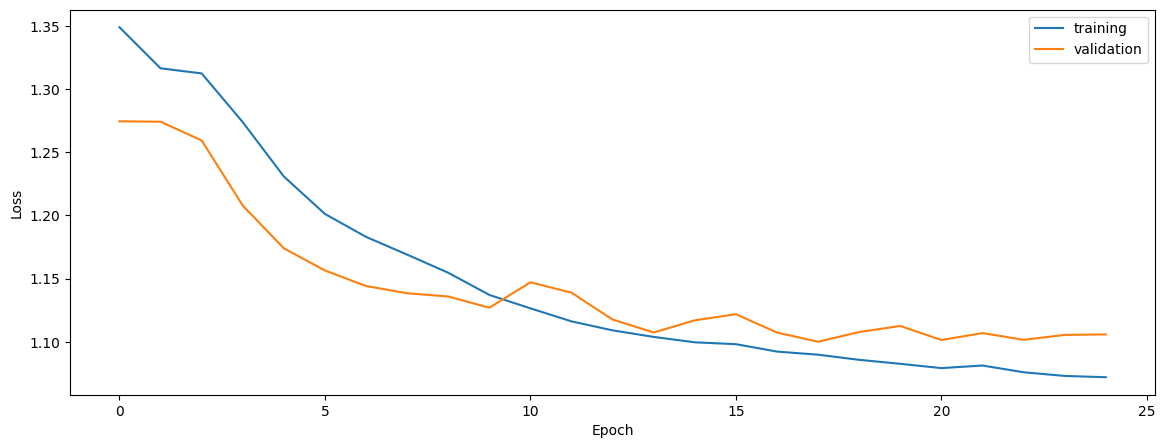

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.632151660780313
0.6489313369152971
0.6668250950570342


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.632151660780313
0.6489313369152971
0.6668250950570342


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6352814219343159
0.6623561272850372
0.6696743907974713


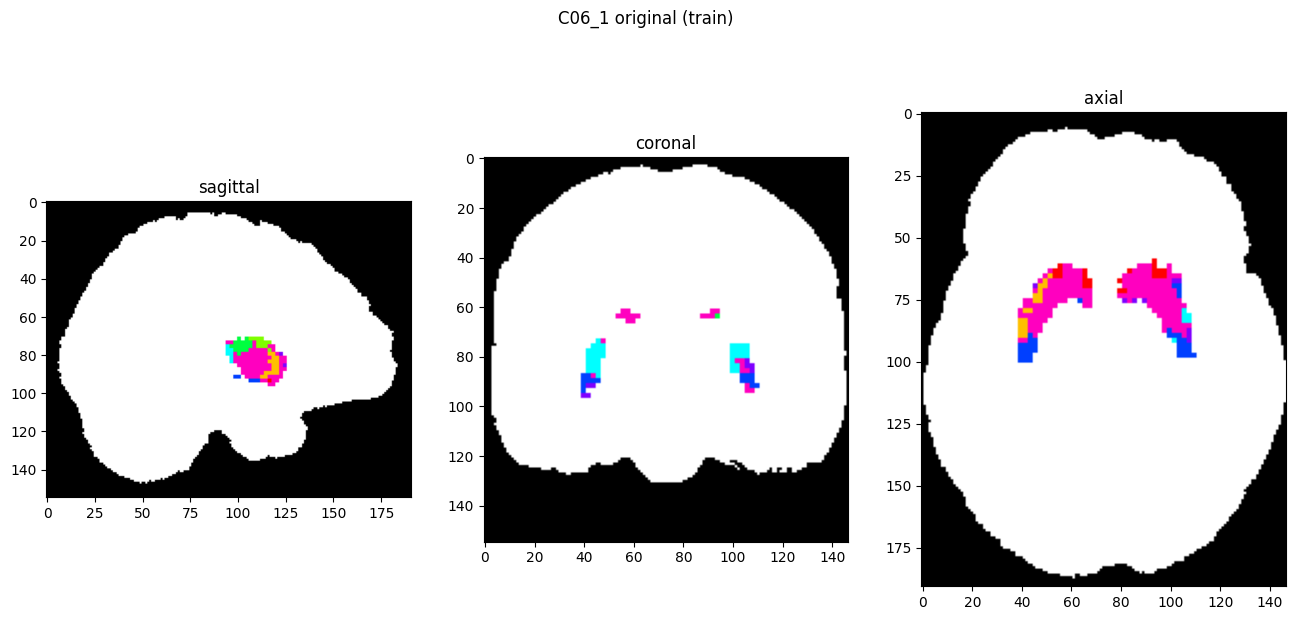

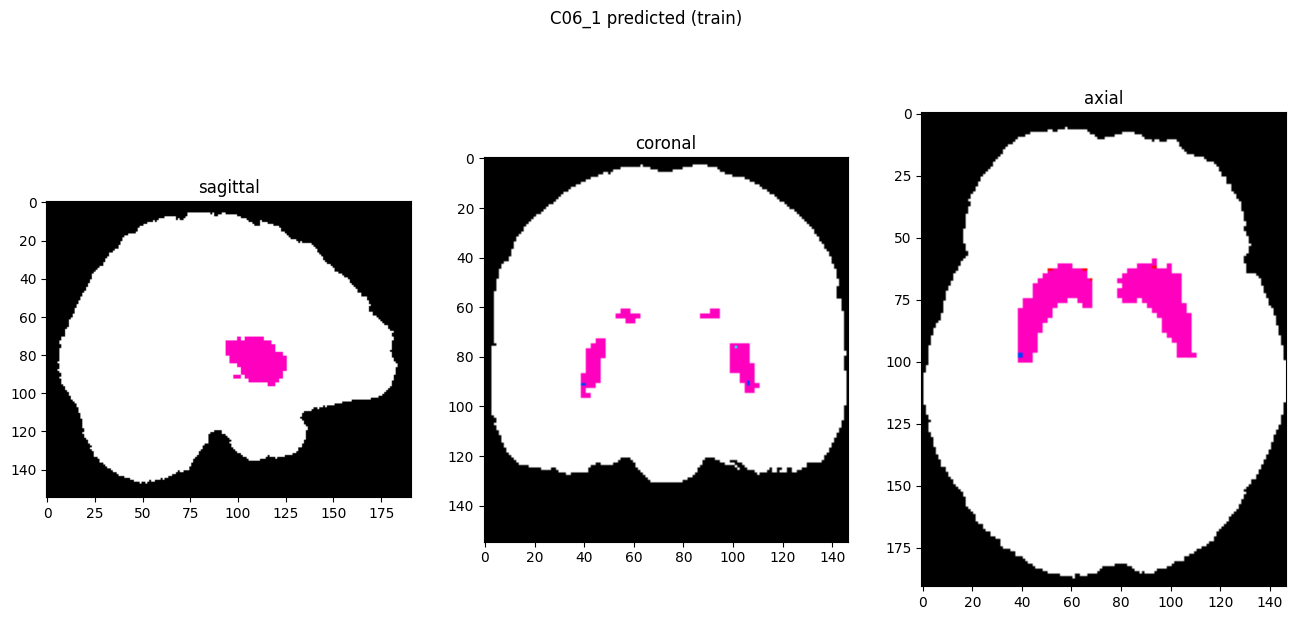

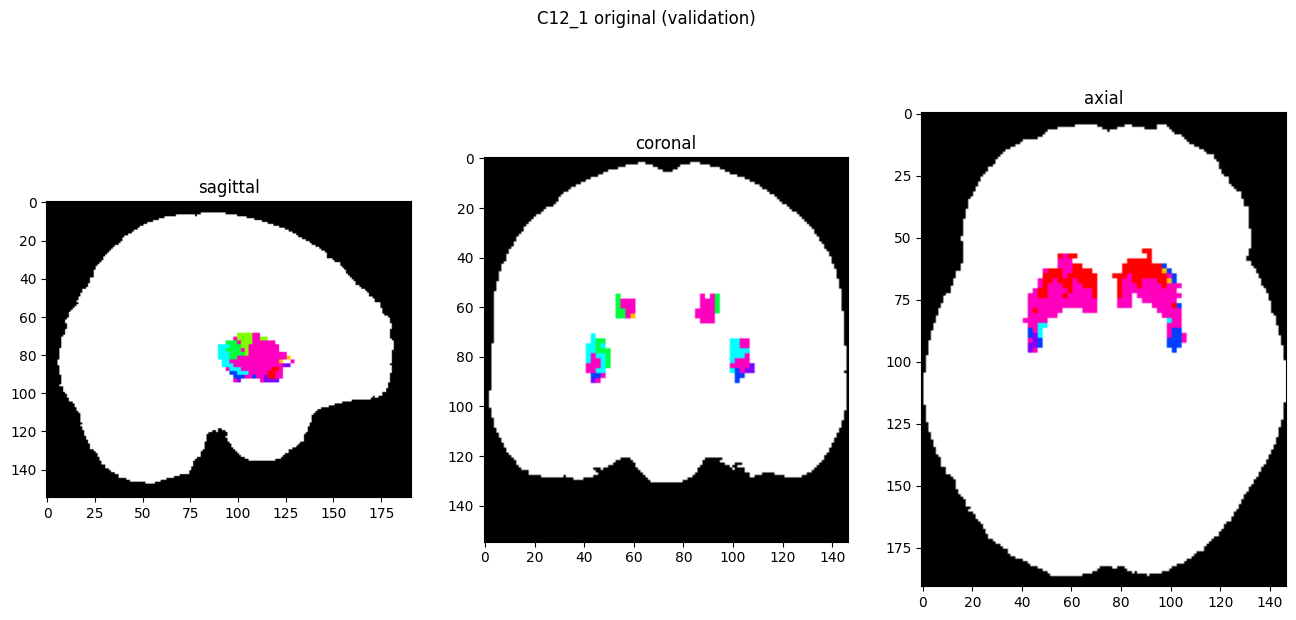

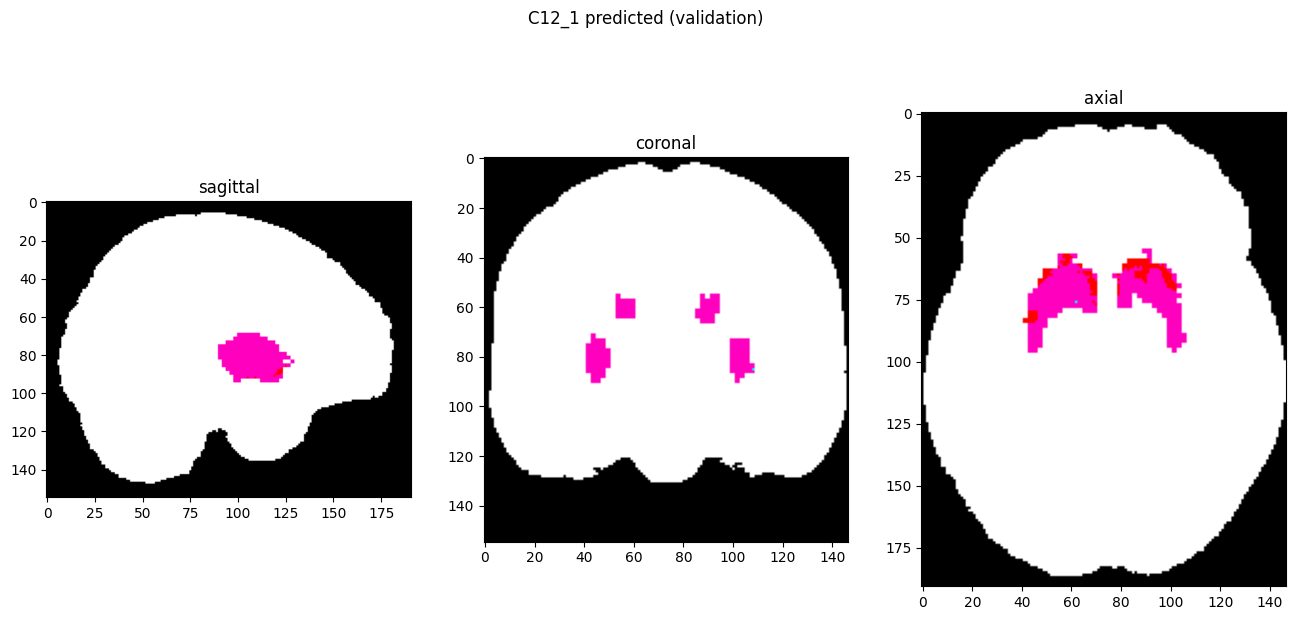

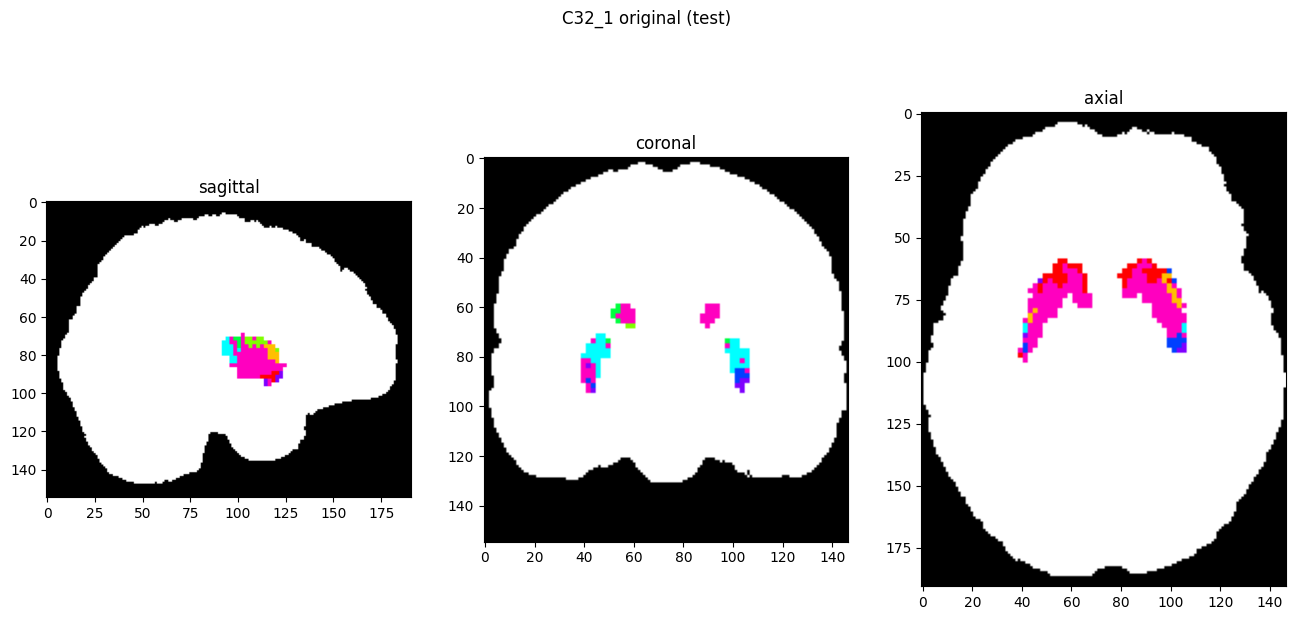

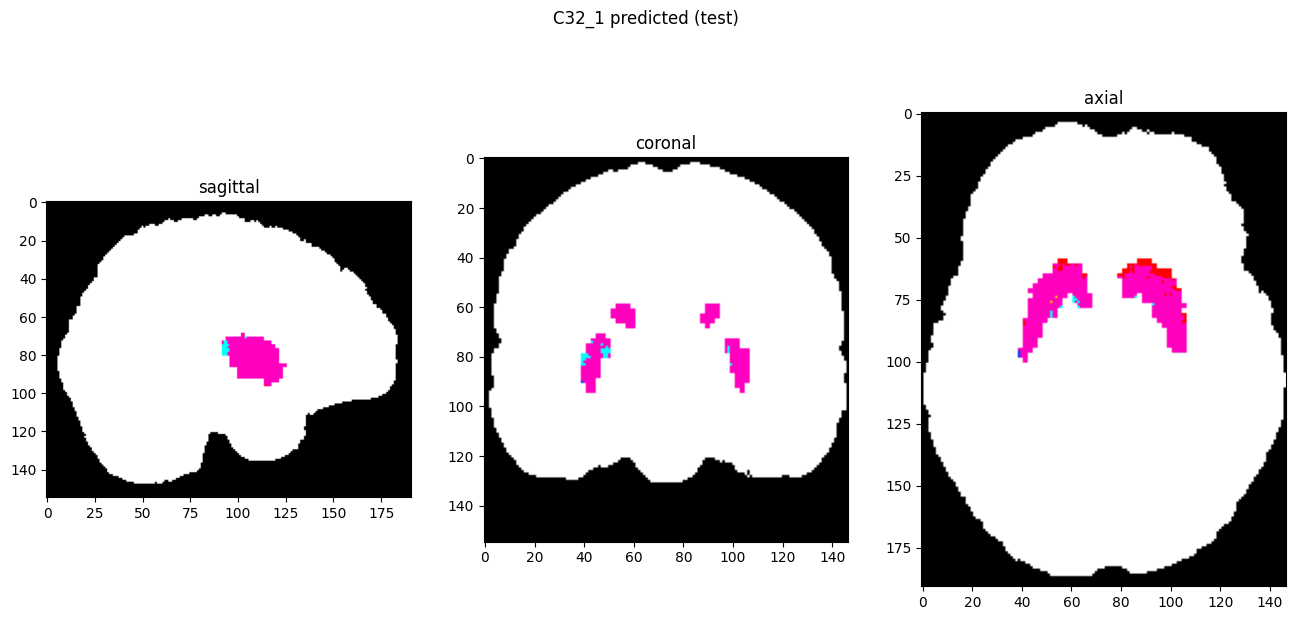

In [10]:
showResults(model, gen, threshold=0)